In [2]:
import time
import copy
import sys
from collections import OrderedDict
from collections import namedtuple
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random 
import pickle
from collections import defaultdict
import math


from mpmath import mp
from scipy import optimize as opt
import matplotlib.pyplot as plt
from matplotlib import cm # for 3d poltting
from mpl_toolkits.mplot3d.axes3d import Axes3D # for 3d poltting
from sympy import symbols, cos, pi
from sympy.core.numbers import One
from sympy.utilities.lambdify import lambdify
from math import sin, pi

In [67]:
class BasicSigmoids:
    @staticmethod
    def sigmoid(x, a, c):
        exponent = (-(x-a))/c
        denom = 1 + (math.e**(exponent))
        return 1/denom
    @staticmethod
    def square(x,a,b,c):
        s1=BasicSigmoids.sigmoid(x, a, c)
        s2=BasicSigmoids.sigmoid(x, b, -c)
        return s1*s2
    @staticmethod
    def scale_up(z,x_min,x_max):
        """
        Scales up z \in [-1,1] to x \in [x_min,x_max]
        where z = (2 * (x - x_min) / (x_max - x_min)) - 1
        """

        return x_min + (z + 1) * (x_max - x_min) / 2
    @staticmethod
    def scale_down(x,x_min,x_max):
        """
        Scales down x \in [x_min,x_max] to z \in [-1,1]
        where z = f(x) = (2 * (x - x_min) / (x_max - x_min)) - 1
        """    

        return (2 * (x - x_min) / (x_max - x_min)) - 1

class ChebyshevApproximator:
    def __init__(self, function, intr, deg, prec = 15, extra_shift=1.0):
        self.extra_shift = extra_shift
        n = deg + 1

        x, u = symbols('x u')

        a, b = intr
        x_to_u = (2 * x - a - b) / (b - a)
        u_to_x = (b - a) / 2 * u + (a + b) / 2
        chebyshev_nodes = cos((symbols('i') + 0.5) / n * pi)

        result_u = [chebyshev_nodes.evalf(prec, subs={'i': i}) for i in range(n)]
        result_x = [u_to_x.evalf(prec, subs={u: i}) for i in result_u]
        result_y = [function(i) for i in result_x]

        t = [One(), u]

        for _ in range(n - 2):
            t.append(2 * u * t[-1] - t[-2])

        c = [sum(result_y) / n]

        for index in range(1, n):
            c.append(2 * sum(t[index].evalf(prec, subs={u: i}) * j for i, j in zip(result_u, result_y)) / n)

        y = 1 * c[0]

        for i in range(1, n):
            y += t[i] * c[i]

        y = y.subs({u: x_to_u}).simplify()

        self.y = y        
        x, u = symbols('x u')    
        self.f = lambdify(x, self.y, "numpy")
        self.f.formula = y
    
    def _get_y(self):
        return self.y
    
    def __call__(self, x):
        return self.f(x)*self.extra_shift
    
    def get_coeffs(self):
        def cheby_to_coeff_list(s): 
            s_coeffs =  [((t.args[1].args[1] if (len(t.args[1].args) != 0)else 1), t.args[0]) for t in s.args[1:]] + [(0, s.args[0])]
            return [x[1] for x in sorted(s_coeffs)]

        return cheby_to_coeff_list(self.y)

class HatChebyshevApproximator(ChebyshevApproximator):
    def __init__(self,a,b,c = 0.005,deg = 10,left = -5,right = 5, extra_shift = 1.001):
        def hat(x):
            return BasicSigmoids.square(x,a,b,c)
        
        super().__init__(hat, (left,right),deg, prec=15, extra_shift=extra_shift)



In [4]:
#Configure GPU (change if not M1 mac)
mps = torch.device("mps")

In [5]:
# Datasets

# Using CIFAR-10 again as in the programming assignments
# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Saving And helpers

def save_tracker(tracker, path):
  np.savetxt(path, tracker, delimiter=',') 

def save_trackers(device, filename):
  """Save all trackers and current total_time to a file."""
  torch.save((device['train_loss_tracker'], device['train_acc_tracker'], device['test_loss_tracker'], device['test_acc_tracker'], total_time), filename)
  print("Saved trackers to " + filename)

def moving_average(a, n=100):
  '''Helper function used for visualization'''
  ret = torch.cumsum(torch.Tensor(a), 0)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

# Plotting helpers! 
def make_plot(trackers, num_epochs, title, y_axis_lab, should_average=False, legend=True, fix_ax=True):
  avg_fn = moving_average if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  if fix_ax:
    ax.set_ylim([0, 100])
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)

  if legend:
    _ = plt.legend()
  plt.show()

def make_plot_better(trackers, num_epochs, title, y_axis_lab, should_average=False, n = 100):
  avg_fn = (lambda x : moving_average(x, n)) if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)
  _ = plt.legend()
  plt.show()

In [7]:
class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentalge of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''
    total_samples = len(dataset)
    sampled = {}
    number_samples = int((data_pct)*(total_samples)) 

    for i in range(num_devices):
      sampled[i] = random.sample(range(total_samples), number_samples)
        
    return sampled

In [8]:
# Neural net definitions

# Same ConvNet as in Assignment 2 and 3
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

In [9]:
# Federated learning helpers

# The baseline `average' function. 
def average_weights(devices,*args, **kwargs):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    state_dicts = [device['net'].state_dict() for device in devices]
#     max_magnitude = 0
    # initialize w_avg to tensors from device 0
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
        w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
#             max_magnitude = max(max_magnitude, abs(torch.max(state_dicts[i][k].type(torch.float32))))
            w_avg[k] += (state_dicts[i][k].type(torch.float32))
        # compute average
        w_avg[k] /= float(len(devices))
    return w_avg


def get_devices_for_round(devices, device_pct):  
    return random.sample(devices, int(device_pct * len(devices)))

def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }

In [10]:
# Local device training and testing
def train(epoch, device, criterion):
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.to(mps), targets.to(mps)
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device, criterion, testloader = testloader):
    device['net'].eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(mps), targets.to(mps)
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)



In [11]:
# Aggregation function tests (the main experiment routine)

# Given two different sets of aggregated weights, 
# gives a value representing the difference between them,
# as a way to measure the direct cost of using our aggregated function
def diff_aggregated_weights(strat, baseline):
    result = 0 
    for k in strat.keys():
        result += torch.linalg.norm(strat[k] - baseline[k])
    return result

# A data type for experiment results
BackdoorResult = namedtuple("BackdoorResult", ["scheme_loss", "test_accuracy", "backdoor_success", "devices", "avg_weight_history"])


def run_federated_test(agg_fn = average_weights,  # Pass in aggregation function, 
                                                  #     device list -> aggregated weights 
                       rounds = 10,               # Rounds of FL
                       local_epochs = 4,          # Epochs per device                      
                       num_devices = 50,          # Total # devices
                       device_pct = 0.2,          # % of devices per round
                       data_pct = 0.1,            # % of data each device gets
                       net = ConvNet().to(mps),   # Network object; make sure on mps backend
                       evil_round = None,         # integer list option; attacker will mount attack during these rounds
                       attacker_strategy = None,  # device -> void; Sets up attacker weight update on device 
                       evil_device_id = None,     # Which device id should perform the attack
                       evaluate_attack = None,    # Evaluated on the set of devices after each round and logged.
                       output_filename = None,    # Write results to disk at this path
                       snapshot = True,           # Snapshot to disk after each round
                       resume_from_snap = None,   # Optionally resume from a prior snapshot.
                       multiple_attack_rounds = []):   
    '''
    Returns instance of BackdoorResult, with following state: 
        scheme_loss        : difference between a straight average and aggregated weights after each round
        test_accuracy      : classification accuracy after each round
        backdoor_success   : result of evaluate_attack(devices) after each round
        devices            : snapshot of devices after each round
        avg_weight_history : snapshot of central server weights after each round
    '''
    
    def lighten_device(d):
        return {
            k: d[k] for k in ( 'id', 'train_loss_tracker', 'train_acc_tracker', 'test_loss_tracker', 'test_acc_tracker')
        }                                   
    
    criterion = nn.CrossEntropyLoss()
    data_idxs = iid_sampler(trainset, num_devices, data_pct)

    devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)]
    
    scheme_loss = []
#     max_magnitudes = []
    avg_weight_history = []
    _starting_round_num = 0
    
    if resume_from_snap: 
        print("Resuming from snapshot!\n")
        # Load what we can
        result = resume_from_snap
        scheme_loss = result.scheme_loss
        avg_weight_history = result.avg_weight_history
        partial_devices = result.devices

        # Fresh data and devices
        criterion = nn.CrossEntropyLoss()
        data_idxs = iid_sampler(trainset, num_devices, data_pct)

        devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)]

        # Restore the devices with the info from the trackers
        def restore_device(old_device, new_device):
            for k in ('id', 'train_loss_tracker', 'train_acc_tracker', 'test_loss_tracker', 'test_acc_tracker'):
                new_device[k] = old_device[k]
            return new_device
        
        print("Restoring devices\n")
        devices = [restore_device(partial_devices[i], devices[i]) for i in range(len(devices))]
        for device in devices:
            device['net'].load_state_dict(avg_weight_history[-1])
        
        _starting_round_num = len(result.test_accuracy)
        print("Finished restoring\n")


        
    ## IID Federated Learning
    start_time = time.time()
    for round_num in range(_starting_round_num, rounds):
        round_start_time = time.time()
        # Part 1.3: Implement getting devices for each round here
        round_devices = get_devices_for_round(devices, device_pct)

        print('Round: ', round_num)
        # Train locally 
        for device in round_devices:
            for local_epoch in range(local_epochs):
                train(local_epoch, device, criterion)
        
        # One device becomes evil if required
        if ((evil_round and round_num == evil_round) or round_num in multiple_attack_rounds):
            assert (evil_device_id is not None)
            assert (attacker_strategy is not None)
            print("Attacking!\n")
            
            attacker_strategy(devices[evil_device_id])
            # Make sure evil guy gets averaged in 
            if evil_device_id not in round_devices:
                round_devices.append(devices[evil_device_id])
            print("Finished attacking\n")
            
        
        # Weight averaging
        w_baseline = average_weights(round_devices)
        w_avg = agg_fn(round_devices, (avg_weight_history[-1] if avg_weight_history != [] else None))
#         max_magnitudes.append(max_magnitude)
        
        # Track the difference between the two; should be 0 if straight average
        scheme_loss.append((float(diff_aggregated_weights(w_avg, w_baseline))))
        
        avg_weight_history.append(copy.deepcopy(w_avg))
        
        # Gradients         
        for device in devices:
            device['net'].load_state_dict(w_avg)
            device['optimizer'].zero_grad()
            device['optimizer'].step()
            device['scheduler'].step()

        # test accuracy after aggregation
        # device 0 is the unique device with all of the 
        # test accuracies and losses in its tracker
        test(round_num, devices[0], criterion)
        
        print(f"\nDiff: {scheme_loss[-1]}\n")
        print(f"Round time: {time.time() - start_time} \n")
        if snapshot:
            intermediate_result = BackdoorResult(
                scheme_loss = scheme_loss, 
                test_accuracy = devices[0]["test_acc_tracker"], 
                backdoor_success = evaluate_attack(devices) if evaluate_attack is not None else None, 
                devices = [lighten_device(d) for d in devices], 
                avg_weight_history = avg_weight_history
            )


            if output_filename is not None: 
                print("Writing snapshot\n")
                with open(f"snapshot_{output_filename}", 'wb') as file: 
                    pickle.dump(intermediate_result, file)
        
    total_time = time.time() - start_time
    print('Total training time: {} seconds'.format(total_time))
    
    # Pack up everything we care about and the devices for good measure
    result = BackdoorResult(
        scheme_loss = scheme_loss, 
        test_accuracy = devices[0]["test_acc_tracker"], 
        backdoor_success = evaluate_attack(devices) if evaluate_attack is not None else None, 
        devices = [lighten_device(d) for d in devices], 
        avg_weight_history = avg_weight_history
    )

    
    if output_filename is not None: 
        with open(output_filename, 'wb') as file: 
            print("Writing file\n")
            pickle.dump(result, file)
    
    return result


# Load output files back into memory
def load_result(filename):
    with open(filename, 'rb') as file: 
        return pickle.load(file)

In [12]:
# Example usage
# results = run_federated_test(local_epochs=1, num_devices = 10, rounds = 2, output_filename = "testout.pickle")

In [13]:
# # Can also load it back
# results = load_result("snapshot_testout.pickle")
# results

In [14]:
# A silly attack that just sends massive weights all of magnitude 10000
def sample_attack(device):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    weights = device["net"].state_dict().copy()
    
    for w in weights.keys():
        weights[w] = torch.full(weights[w].size(), 10000)
    
    device['net'].load_state_dict(weights)

In [15]:
# Aggregation function that squashes any weights with magnitude over 1000 (except on the first device but whatever)
def super_smart_aggregation(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights, excluding huge updates.
    '''
    state_dicts = [device['net'].state_dict() for device in devices]
    # initialize w_avg to tensors from device 0
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
        w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
            if (torch.max(state_dicts[i][k].type(torch.float32)) <= 1000): 
                w_avg[k] += (state_dicts[i][k].type(torch.float32))
        # compute average
        w_avg[k] /= float(len(devices))
    return w_avg

In [16]:
# Example of how this works

# Here, we carry out the attack but use the ordinary average
# results_straight_avg = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
#                                          rounds = 3,              
#                                          local_epochs = 1,                             
#                                          num_devices = 10,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = 1,        
#                                          attacker_strategy = sample_attack,  
#                                          evil_device_id = 2,     
#                                          evaluate_attack = None, 
#                                          output_filename = "baseline_trivial_attack.pickle")  
# Observe that it absolutely destroys our model

In [17]:
# Now we do it again but with the aggregation that rejects huge updates
# results_reject_huge = run_federated_test(agg_fn = super_smart_aggregation,                    
#                                          rounds = 3,              
#                                          local_epochs = 1,                             
#                                          num_devices = 10,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = 1,        
#                                          attacker_strategy = sample_attack,  
#                                          evil_device_id = 2,     
#                                          evaluate_attack = None,
#                                          output_filename = "simple_attack_and_defense.pickle")  

In [18]:
# Here, we compute a real baseline over 100 epochs and typical averaging. Good starting point for future 
# tests; can resume from this snapshot.
# baseline = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
#                                          rounds = 100,              
#                                          local_epochs = 4,                             
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evaluate_attack = None, 
#                                          output_filename = "baseline.pickle")  

In [28]:
baseline = load_result("baseline.pickle")

In [20]:
# For example, now can get things like
# baseline.test_accuracy

In [21]:
# We can resume from a snapshot:
# NOTE : keep all the basic params (local epochs, num devices, net, etc) the same
# when resuming from a snapshot 
# baseline2 = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
#                                          rounds = 101,              
#                                          local_epochs = 4,                             
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evaluate_attack = None, 
#                                          output_filename = "baseline2.pickle", 
#                                          resume_from_snap = baseline )  # we pass in a results object here

In [22]:
# baseline2_loaded = load_result("baseline2.pickle")
# baseline2

In [23]:
# Now we can move on to a real defense. 

# We create factory functions that let us parametrize a double sigmoid using threshholds

def torch_scaled_sigmoid_factory(a, c = 0.005, left = False):
    
    def f(x):
        scaled = torch.sub(x, a)

        divisor = c if left else -1*c

        scaled = torch.div(scaled, divisor)

        return torch.sigmoid(scaled)
    return f

def torch_double_sigmoid_factory(a,b,c = 0.005):
    left = torch_scaled_sigmoid_factory(a, left = True)
    right = torch_scaled_sigmoid_factory(b, left = False) 
    def f(x):
        return (left(x)*right(x))
    return f

my_sigmoid = torch_double_sigmoid_factory(-1,1)

In [24]:
# torch_double_sigmoid_factory(-1,6)(torch.tensor(list(range(-5,10))))

In [25]:
# Make sure it works
# torch_double_sigmoid_factory(-2,2)(torch.Tensor([-5,-4,-3,-2,-1.5,-1.4,1.3,-1,0,1,1.5,1.6,2,3,4]))

In [94]:
# Creates a sigmoid defense,
#     keys_to_range_mapping maps each layer name in the state dict to the sigmoid bounds for processing it
#     All other layers just get identity function-ed
# watcher = {}
def make_sigmoid_defense(keys_to_range_mapping, stickiness = 0, sigmoid_function_on_ab = torch_double_sigmoid_factory):
    
    sigmoid_dict = defaultdict(lambda : (lambda x: 1))
    
    for k,(a,b) in keys_to_range_mapping.items():
        sigmoid_dict[k] = sigmoid_function_on_ab(a,b)
    
    def f(devices, previous_round_weights):
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights preprocessed by sigmoid
        '''
        
        state_dicts = [device['net'].state_dict() for device in devices]
        sigmoid_result_per_device = [1]*len(devices)
        # initialize w_avg to tensors from device 0
        w_avg = copy.deepcopy(state_dicts[0])

        # get the sigmoids
        for i in range(len(devices)):
            for k in w_avg.keys():
                sig = sigmoid_dict[k]
                new_weight = (state_dicts[i][k].type(torch.float32))
                prev_round_x = previous_round_weights[k].type(torch.float32)  if (previous_round_weights is not None) else new_weight
                r = sig(torch.sub(new_weight, prev_round_x))
                print(r)
                sigmoid_result_per_device[i] *= ((torch.mean(r) if (type(r) not in [int, float]) else r)**5)
                
        
        print("Sigmoids!:\n")
        print(sigmoid_result_per_device)

        
        for k in w_avg.keys():
            sig = sigmoid_dict[k]
            new_weight = w_avg[k].type(torch.float32)
            w_avg[k] = new_weight*sigmoid_result_per_device[0]
            # optionally count the old average a bunch of times
            
            prev_round_x = previous_round_weights[k].type(torch.float32)  if (previous_round_weights is not None) else new_weight
            for i in range(stickiness):
                w_avg[k] += prev_round_x            

        # for each model param
        for k in w_avg.keys():
            # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k], scaling by sig
            for i in range(1, len(devices)):
                new_weight = (state_dicts[i][k].type(torch.float32))
                w_avg[k] += new_weight*sigmoid_result_per_device[i]
                
            # compute average
            w_avg[k] /= float(sum(sigmoid_result_per_device) + stickiness)
        return w_avg
    
    return f

In [95]:
# These are the actual layer weights that we care about
[x for x in baseline.avg_weight_history[-1].keys() if '.0.weight' in x]

['model.0.0.weight',
 'model.1.0.weight',
 'model.2.0.weight',
 'model.3.0.weight',
 'model.4.0.weight',
 'model.5.0.weight',
 'model.6.0.weight',
 'model.7.0.weight',
 'model.8.0.weight']

In [96]:
# Now lets set up a potential sigmoid defense
# empirical_cutoffs = {
#     'model.0.0.weight' : (-2,2),
#     'model.1.0.weight' : (-2,2),
#     'model.2.0.weight' : (-.7,.7),
#     'model.3.0.weight' : (-.6,.6),
#     'model.4.0.weight' : (-0.7,0.7),
#     'model.5.0.weight' : (-0.5,0.5),
#     'model.6.0.weight' : (-0.3,0.3),
#     'model.7.0.weight' : (-0.2,0.2),
#     'model.8.0.weight' : (-0.2,0.2),
# }
# empirical_cutoffs = {
#     'model.0.0.weight' : (-0.3,0.3),
#     'model.1.0.weight' : (-0.3,0.3),
#     'model.2.0.weight' : (-0.3,0.3),
#     'model.3.0.weight' : (-0.3,0.3),
#     'model.4.0.weight' : (-0.3,0.3),
#     'model.5.0.weight' : (-0.3,0.3),
#     'model.6.0.weight' : (-0.3,0.3),
#     'model.7.0.weight' : (-0.1,0.1),
#     'model.8.0.weight' : (-0.1,0.1),
# }
empirical_cutoffs = {
    'model.0.0.weight' : (-1,1),
    'model.1.0.weight' : (-0.3,0.3),
    'model.2.0.weight' : (-0.3,0.3),
    'model.3.0.weight' : (-0.3,0.3),
    'model.4.0.weight' : (-0.3,0.3),
    'model.5.0.weight' : (-0.3,0.3),
    'model.6.0.weight' : (-0.3,0.3),
    'model.7.0.weight' : (-0.1,0.1),
    'model.8.0.weight' : (-0.1,0.1),
}
# empirical_cutoffs = {
#     'model.0.0.weight' : (-1,1),
#     'model.1.0.weight' : (-1,1),
#     'model.2.0.weight' : (-1,1),
#     'model.3.0.weight' : (-1,1),
#     'model.4.0.weight' : (-1,1),
#     'model.5.0.weight' : (-1,1),
#     'model.6.0.weight' : (-1,1),
#     'model.7.0.weight' : (-1,1),
#     'model.8.0.weight' : (-1,1),
# }
sigmoid_aggregation = make_sigmoid_defense(empirical_cutoffs, stickiness=0, sigmoid_function_on_ab=HatChebyshevApproximator)

In [97]:
# sigmoid_resumption = run_federated_test(agg_fn = sigmoid_accuracy,                    
#                                          rounds = 110,              
#                                          local_epochs = 1,                             
#                                          num_devices = 50,         
#                                          device_pct = 0.05,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evaluate_attack = None, 
#                                          output_filename = None,
#                                          snapshot = False,
#                                          resume_from_snap = baseline )  # we pass in a results object here

In [98]:
# Now lets make an attack
# Makes an attack that puts noise in all of target layers. 
# Noise is uniform over a,b
def noise_attack_factory(target_layers, a,b):
    def attack(device):
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights.
        '''
        weights = device["net"].state_dict().copy()

        for w in weights.keys():
            if w in target_layers:
                weights[w] = (a - b) * torch.rand(weights[w].size()) + b

        device['net'].load_state_dict(weights)
    return attack

In [102]:
# We attack these layers with weights ranging from -4,4
target_layers = ['model.0.0.weight',
 'model.1.0.weight',
 'model.2.0.weight',
 'model.3.0.weight',
 'model.4.0.weight',
 'model.5.0.weight',
 'model.6.0.weight',
 'model.7.0.weight',
 'model.8.0.weight']
big_noise_attack = noise_attack_factory(target_layers,-.1,.1)

In [103]:
# We'll resume from our baseline model


In [104]:
baseline = load_result("baseline.pickle")
determine_cutoffs_2 = run_federated_test( agg_fn = sigmoid_aggregation,                    
                                         rounds = 105, # go 30 pounds past where the baseline left off              
                                         local_epochs = 0,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.05,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = None, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = big_noise_attack, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = None,
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = False, 
                                        multiple_attack_rounds=[100,101,102,103,104]) # 

Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
Attacking!

Finished attacking

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

        

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[0.9855, 0.9859, 0.9870],
          [0.9402, 0.9733, 0.9747],
          [0.9824, 1.0009, 0.9987]],

         [[0.9999, 0.9534, 0.9971],
          [0.9735, 1.0002, 0.9956],
          [0.9740, 0.8902, 0.9530]],

         [[0.9968, 0.9459, 0.9872],
          [0.9682, 0.9883, 0.9513],
          [0.9897, 0.9776, 0.9988]],

         ...,

         [[1.0009, 0.9887, 0.9968],
          [0.9903, 1.0010, 0.9973],
          [0.9940, 0.9947, 1.0006]],

         [[1.0010, 0.9895, 0.9997],
          [1.0001, 1.0007, 1.0000],
          [1.0010, 0.9944, 0.9742]],

         [[0.9998, 0.9979, 0.9939],
          [0.9957, 0.9777, 1.0009],
          [0.9986, 1.0008, 0.9957]]],


        [[[0.9982, 0.9670, 1.0002],
          [1.0002, 0.9980, 1.0000],
          [0.9999, 0.9997, 1.0010]],

         [[1.0002, 1.0000, 0.9969],
          [0.9980, 0.9778, 0.9955],
          [0.9880, 0.9984, 0.9994]],

         [[0.9944, 0.9754, 0.9863],
          [0.9982, 0.9964, 0.9815],
          [0.9891, 1.0009, 0.99

tensor([[[[0.9973, 0.9939, 0.9980],
          [0.9984, 0.9785, 0.9964],
          [0.9950, 0.9947, 1.0000]],

         [[1.0001, 0.9983, 0.9748],
          [0.9871, 0.9840, 0.9958],
          [1.0008, 0.9922, 0.9960]],

         [[1.0003, 0.9983, 1.0006],
          [0.9953, 0.9997, 1.0010],
          [0.9975, 0.9923, 1.0001]],

         ...,

         [[1.0009, 1.0007, 0.9999],
          [0.9992, 0.9925, 0.9990],
          [0.9866, 0.9988, 0.9883]],

         [[0.9927, 0.9793, 0.9876],
          [1.0010, 0.9990, 0.9969],
          [0.9967, 0.9917, 1.0008]],

         [[0.9551, 0.9229, 0.9806],
          [0.9442, 0.9606, 0.9911],
          [0.9948, 1.0001, 1.0001]]],


        [[[0.9815, 0.9969, 0.9949],
          [1.0007, 1.0001, 0.9626],
          [0.9965, 1.0010, 0.9638]],

         [[0.9702, 1.0007, 0.9787],
          [0.9965, 0.9663, 0.9875],
          [0.9923, 0.9455, 0.9830]],

         [[0.9792, 1.0010, 1.0009],
          [0.9994, 1.0010, 0.9802],
          [0.9999, 0.9761, 0.95

1
tensor([[[[0.9998, 0.9906, 0.9981],
          [1.0006, 1.0010, 1.0010],
          [0.9830, 0.9989, 0.9890]],

         [[0.9999, 0.9983, 1.0001],
          [0.9808, 0.9875, 1.0008],
          [0.9995, 1.0009, 1.0009]],

         [[0.9981, 0.9911, 1.0010],
          [0.9942, 1.0002, 0.9953],
          [0.9917, 0.9973, 1.0005]],

         ...,

         [[1.0002, 0.9871, 1.0007],
          [0.9905, 0.9986, 0.9998],
          [0.9998, 1.0001, 0.9985]],

         [[0.9688, 0.9964, 0.9935],
          [0.9865, 0.9999, 0.9839],
          [1.0009, 0.9945, 1.0001]],

         [[1.0007, 0.9980, 0.9996],
          [0.9994, 1.0006, 0.9902],
          [1.0007, 0.9920, 1.0007]]],


        [[[0.9994, 0.9913, 1.0004],
          [0.9932, 0.9983, 1.0000],
          [1.0010, 0.9898, 1.0008]],

         [[0.9988, 0.9994, 0.9989],
          [0.9990, 0.9920, 1.0001],
          [1.0007, 1.0010, 0.9915]],

         [[0.9866, 0.9761, 0.9988],
          [0.9951, 0.9931, 1.0008],
          [0.9958, 0.9992, 0.

1
1
1
1
1
1
1
Sigmoids!:

[tensor(1.0460, device='mps:0'), tensor(1.0460, device='mps:0'), tensor(0.3144, device='mps:0')]
 | Test Loss: 0.983 | Test Acc: 70.340

Diff: 45.38755798339844

Round time: 10.907257080078125 

Round:  101
Attacking!

Finished attacking

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

1
1
1
tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010

tensor([[[[0.9972, 1.0007, 0.9965],
          [0.9894, 0.9793, 1.0006],
          [1.0002, 0.9976, 0.9880]],

         [[0.9946, 0.9873, 1.0001],
          [1.0003, 1.0002, 0.9825],
          [0.9654, 0.9064, 0.9428]],

         [[1.0001, 0.9592, 0.9796],
          [0.9583, 0.9772, 0.9634],
          [0.9984, 0.9928, 0.9997]],

         ...,

         [[1.0000, 1.0010, 0.9946],
          [0.9994, 1.0006, 0.9926],
          [1.0005, 1.0006, 1.0007]],

         [[1.0009, 0.9904, 1.0010],
          [0.9987, 0.9932, 0.9837],
          [0.9776, 0.9996, 0.9928]],

         [[0.9906, 1.0000, 0.9997],
          [0.9792, 0.9980, 0.9984],
          [1.0006, 0.9899, 0.9998]]],


        [[[0.9855, 0.9973, 0.9965],
          [0.9961, 0.9982, 0.9982],
          [1.0004, 0.9970, 1.0004]],

         [[0.9973, 1.0005, 1.0010],
          [1.0007, 0.9836, 1.0010],
          [0.9924, 0.9863, 0.9951]],

         [[1.0005, 1.0005, 1.0010],
          [0.9909, 1.0009, 0.9825],
          [1.0004, 0.9994, 0.99

tensor([[[[1.0005, 1.0003, 1.0004],
          [0.9929, 0.9700, 0.9757],
          [0.9897, 0.9967, 1.0006]],

         [[0.9883, 0.9948, 0.9972],
          [0.9984, 0.9928, 1.0007],
          [1.0003, 1.0009, 0.9914]],

         [[0.9979, 1.0009, 0.9925],
          [1.0001, 0.9999, 0.9987],
          [1.0001, 1.0002, 1.0004]],

         ...,

         [[0.9988, 1.0006, 0.9995],
          [0.9950, 0.9961, 0.9772],
          [0.9996, 0.9850, 0.9865]],

         [[0.9970, 0.9917, 0.9914],
          [0.9946, 1.0001, 1.0005],
          [1.0010, 0.9911, 1.0005]],

         [[0.9805, 0.9687, 1.0005],
          [0.9716, 0.9765, 0.9973],
          [0.9999, 1.0006, 0.9988]]],


        [[[1.0004, 0.9885, 0.9912],
          [1.0003, 0.9987, 0.9993],
          [1.0004, 0.9945, 0.9801]],

         [[0.9998, 1.0009, 0.9891],
          [1.0008, 0.9791, 0.9898],
          [0.9918, 0.9635, 0.9758]],

         [[0.9968, 0.9884, 0.9838],
          [0.9979, 1.0008, 0.9663],
          [0.9956, 0.9963, 0.99

tensor([[[[1.0009, 0.9976, 1.0003],
          [0.9933, 0.9976, 0.9978],
          [0.9916, 0.9995, 1.0007]],

         [[0.9920, 0.9742, 1.0006],
          [0.9988, 0.9839, 1.0009],
          [1.0005, 1.0008, 0.9977]],

         [[1.0010, 0.9997, 0.9917],
          [0.9921, 0.9974, 0.9988],
          [1.0006, 1.0009, 0.9910]],

         ...,

         [[1.0004, 0.9977, 1.0004],
          [0.9981, 0.9999, 1.0008],
          [0.9982, 0.9857, 0.9979]],

         [[1.0010, 0.9941, 0.9988],
          [0.9968, 1.0010, 1.0006],
          [1.0010, 0.9906, 1.0005]],

         [[0.9975, 1.0009, 0.9945],
          [1.0003, 0.9989, 1.0002],
          [0.9770, 1.0009, 1.0008]]],


        [[[0.9954, 0.9886, 1.0009],
          [1.0008, 0.9973, 0.9995],
          [0.9925, 0.9998, 0.9947]],

         [[0.9914, 0.9978, 1.0006],
          [0.9965, 0.9974, 0.9954],
          [0.9992, 0.9996, 0.9992]],

         [[0.9772, 0.9935, 0.9981],
          [1.0003, 1.0007, 1.0009],
          [0.9942, 0.9982, 0.99

tensor([[[[0.9997, 0.9985, 0.9995],
          [0.9952, 0.9996, 0.9960],
          [1.0007, 1.0000, 0.9973]],

         [[1.0008, 0.9989, 1.0007],
          [1.0001, 0.9909, 0.9927],
          [1.0008, 0.9935, 0.9908]],

         [[1.0003, 0.9992, 1.0008],
          [1.0009, 0.9997, 0.9915],
          [0.9976, 1.0009, 0.9971]],

         ...,

         [[0.9989, 1.0008, 1.0003],
          [1.0002, 0.9932, 0.9964],
          [0.9978, 0.9956, 1.0008]],

         [[1.0009, 0.9951, 0.9972],
          [1.0005, 1.0001, 1.0006],
          [1.0006, 0.9990, 0.9985]],

         [[0.9999, 0.9992, 0.9999],
          [0.9972, 0.9973, 1.0007],
          [0.9938, 0.9953, 1.0005]]],


        [[[0.9930, 0.9990, 0.9936],
          [0.9981, 0.9934, 1.0004],
          [1.0002, 0.9951, 0.9956]],

         [[0.9947, 1.0006, 1.0008],
          [1.0010, 1.0006, 0.9984],
          [1.0009, 0.9998, 0.9956]],

         [[0.9969, 1.0005, 0.9961],
          [0.9942, 0.9950, 0.9918],
          [0.9987, 0.9978, 0.99

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

1
1
1
1
1
tensor([[[[0.9834, 0.9859, 0.9993],
          [0.9972, 0.9983, 0.9818],
          [0.9999, 0.9896, 1.0007]],

         [[1.0010, 0.9792, 0.9997],
          [0.9973, 0.9965, 1.0008],
          [0.9736, 0.9225, 0.9852]],

         [[0.9969, 0.9839, 0.9871],
          [0.9780, 0.9906, 0.9798],
          [1.0007, 1.0006, 0.9953]],

         ...,

         [[0.9979, 1.0003, 1.0004],
          [0.9951, 0.9990, 0.9999],
          [0.9862, 0.9990, 1.0006]],

         [[0.9895, 0.9950, 1.0010],
          [1.0008, 1.0009, 0.9998],
          [1.0010, 0.9995, 0.9999]],

         [[0.9989, 0.9942, 0.9993],
          [1.0009, 0.9949, 0.9971],
          [1.0008, 0.9999, 0.9955]]],


        [[[0.9908, 0.9808, 0.9975],
          [0.9957, 0.9841, 0.9974],
          [1.0007, 0.9992, 1.0003]],

         [[0.9917, 0.9983, 1.0002],
          [0.9966, 1.0006, 0.9958],
          [1.0006, 1.0007, 0.9990]],

         [[0.9995, 0.9970, 0.9897],
          [1.0010, 1.0005, 1.0010],
          [0.9994, 0.

tensor([[[[1.0010, 1.0005, 1.0000],
          [1.0001, 0.9961, 0.9969],
          [1.0008, 0.9892, 1.0009]],

         [[0.9824, 1.0010, 1.0008],
          [0.9954, 0.9973, 0.9988],
          [0.9994, 0.9970, 1.0010]],

         [[0.9984, 0.9935, 0.9936],
          [0.9942, 0.9896, 1.0010],
          [1.0006, 0.9979, 0.9966]],

         ...,

         [[0.9994, 0.9996, 1.0004],
          [1.0010, 1.0001, 0.9968],
          [0.9783, 1.0008, 1.0000]],

         [[0.9896, 0.9944, 1.0004],
          [1.0007, 1.0009, 0.9987],
          [1.0009, 0.9999, 1.0000]],

         [[0.9982, 0.9923, 1.0010],
          [0.9979, 1.0003, 1.0010],
          [1.0010, 1.0001, 0.9938]]],


        [[[0.9938, 1.0010, 0.9937],
          [1.0009, 0.9999, 0.9952],
          [1.0008, 1.0007, 0.9866]],

         [[1.0004, 0.9987, 0.9916],
          [0.9993, 1.0010, 0.9910],
          [0.9991, 0.9924, 1.0008]],

         [[0.9967, 1.0009, 0.9965],
          [0.9997, 1.0010, 0.9995],
          [1.0006, 1.0006, 0.99

tensor([[[[1.0004, 1.0009, 0.9999],
          [0.9970, 0.9955, 1.0010],
          [0.9994, 0.9846, 0.9993]],

         [[0.9872, 0.9956, 1.0001],
          [0.9860, 0.9991, 0.9939],
          [1.0008, 0.9969, 0.9995]],

         [[0.9943, 0.9981, 1.0001],
          [0.9963, 0.9937, 0.9981],
          [0.9954, 0.9990, 0.9907]],

         ...,

         [[0.9970, 0.9971, 0.9913],
          [0.9990, 0.9981, 1.0010],
          [1.0001, 0.9915, 0.9984]],

         [[1.0009, 0.9957, 0.9976],
          [1.0010, 1.0010, 0.9978],
          [0.9948, 0.9984, 0.9930]],

         [[0.9954, 0.9952, 0.9960],
          [1.0005, 0.9953, 0.9984],
          [0.9871, 0.9984, 1.0001]]],


        [[[1.0001, 1.0010, 0.9931],
          [0.9949, 0.9967, 0.9964],
          [0.9999, 1.0003, 0.9876]],

         [[1.0000, 0.9940, 0.9973],
          [0.9995, 0.9963, 1.0008],
          [0.9940, 0.9907, 1.0010]],

         [[0.9870, 1.0006, 1.0007],
          [1.0010, 1.0009, 0.9990],
          [0.9971, 0.9952, 0.99

 | Test Loss: 6.376 | Test Acc: 10.000

Diff: 27.182527542114258

Round time: 31.417696952819824 

Round:  103
Attacking!

Finished attacking

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[0.9994, 1.0006, 0.9962],
          [0.9692, 0.9879, 0.9805],
          [1.0006, 0.9983, 1.0004]],

         [[1.0001, 0.9997, 0.9850],
          [1.0010, 0.9938, 0.9951],
          [0.9828, 0.9901, 0.9857]],

         [[0.9969, 0.9958, 0.9736],
          [0.9888, 0.9732, 0.9839],
          [0.9939, 1.0010, 0.9916]],

         ...,

         [[1.0002, 0.9937, 1.0000],
          [1.0006, 1.0009, 1.0010],
          [0.9989, 0.9933, 0.9952]],

         [[1.0001, 1.0009, 1.0010],
          [0.9970, 0.9979, 0.9996],
          [0.9962, 0.9980, 1.0006]],

         [[0.9911, 0.9984, 1.0000],
          [0.9915, 1.0008, 1.0007],
          [0.9846, 0.9882, 0.9983]]],


        [[[1.0010, 1.0005, 0.9971],
          [0.9963, 0.9996, 1.0006],
          [1.0009, 0.9985, 0.9945]],

         [[0.9995, 0.9992, 1.0010],
          [0.9912, 0.9893, 0.9934],
          [1.0010, 1.0005, 0.9932]],

         [[0.9963, 1.0005, 1.0009],
          [0.9947, 1.0010, 1.0009],
          [0.9999, 0.9926, 1.00

tensor([[[[1.0008, 0.9932, 0.9969],
          [0.9990, 0.9962, 0.9965],
          [0.9926, 0.9995, 0.9997]],

         [[1.0002, 0.9981, 0.9671],
          [0.9847, 0.9919, 1.0006],
          [0.9946, 1.0007, 0.9995]],

         [[1.0005, 0.9967, 1.0009],
          [0.9984, 1.0004, 1.0010],
          [1.0002, 0.9982, 1.0009]],

         ...,

         [[0.9884, 0.9988, 0.9955],
          [0.9930, 0.9955, 0.9818],
          [1.0003, 0.9992, 1.0005]],

         [[0.9993, 0.9997, 1.0010],
          [0.9985, 0.9960, 0.9993],
          [0.9997, 0.9947, 0.9996]],

         [[1.0010, 0.9943, 0.9970],
          [0.9850, 1.0001, 0.9879],
          [1.0010, 0.9968, 0.9961]]],


        [[[1.0010, 1.0000, 0.9948],
          [1.0007, 0.9947, 0.9909],
          [1.0008, 1.0006, 0.9945]],

         [[0.9830, 0.9965, 0.9840],
          [0.9955, 0.9919, 0.9982],
          [1.0002, 0.9993, 0.9845]],

         [[0.9998, 0.9969, 1.0009],
          [1.0007, 1.0007, 1.0010],
          [0.9997, 0.9986, 0.99

tensor([[[[0.9987, 1.0009, 1.0005],
          [1.0000, 1.0006, 0.9998],
          [0.9974, 0.9984, 0.9917]],

         [[1.0010, 0.9879, 0.9983],
          [1.0001, 1.0009, 1.0010],
          [0.9984, 1.0007, 0.9979]],

         [[0.9917, 0.9990, 0.9907],
          [1.0005, 1.0010, 1.0005],
          [0.9992, 1.0004, 1.0006]],

         ...,

         [[0.9991, 1.0009, 0.9990],
          [0.9989, 1.0009, 0.9986],
          [1.0005, 0.9963, 0.9949]],

         [[1.0009, 0.9896, 0.9989],
          [1.0010, 0.9999, 0.9944],
          [0.9973, 0.9945, 0.9904]],

         [[0.9944, 0.9998, 0.9983],
          [0.9991, 1.0003, 1.0010],
          [1.0005, 0.9962, 0.9969]]],


        [[[0.9972, 1.0004, 1.0008],
          [0.9972, 1.0003, 1.0010],
          [0.9978, 0.9975, 1.0005]],

         [[1.0009, 0.9945, 0.9941],
          [0.9905, 0.9966, 0.9986],
          [0.9949, 1.0009, 0.9964]],

         [[0.9939, 0.9993, 1.0007],
          [1.0006, 1.0010, 0.9971],
          [0.9996, 1.0004, 1.00

tensor([[[[1.0008, 0.9998, 0.9992],
          [0.9977, 0.9978, 1.0010],
          [1.0004, 0.9997, 1.0010]],

         [[0.9976, 1.0002, 1.0000],
          [0.9981, 1.0000, 0.9914],
          [1.0004, 1.0008, 0.9986]],

         [[0.9986, 0.9990, 0.9991],
          [1.0001, 1.0002, 0.9950],
          [0.9919, 1.0009, 1.0010]],

         ...,

         [[0.9893, 0.9981, 1.0009],
          [0.9962, 0.9984, 1.0002],
          [1.0006, 1.0008, 1.0002]],

         [[0.9992, 0.9998, 0.9964],
          [1.0009, 0.9997, 0.9969],
          [0.9920, 1.0008, 0.9973]],

         [[0.9984, 1.0003, 0.9900],
          [1.0009, 0.9946, 0.9990],
          [1.0000, 0.9961, 1.0010]]],


        [[[0.9958, 0.9980, 1.0005],
          [0.9989, 0.9959, 0.9980],
          [0.9915, 1.0010, 0.9995]],

         [[0.9991, 0.9990, 0.9981],
          [0.9993, 0.9999, 0.9979],
          [1.0010, 0.9970, 0.9994]],

         [[0.9995, 1.0009, 0.9992],
          [0.9971, 0.9980, 1.0008],
          [0.9962, 0.9996, 0.99

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         ...,

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]]],


        [[[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010]],

         [[1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.0010],
          [1.0010, 1.0010, 1.00

tensor([[[[0.9974, 0.9984, 0.9744],
          [0.9909, 0.9871, 1.0005],
          [1.0006, 0.9835, 0.9861]],

         [[0.9993, 0.9954, 0.9811],
          [0.9960, 1.0010, 1.0010],
          [0.9740, 0.9888, 0.9875]],

         [[0.9996, 1.0009, 1.0006],
          [1.0001, 1.0007, 0.9998],
          [1.0001, 0.9851, 0.9982]],

         ...,

         [[1.0000, 0.9988, 0.9892],
          [0.9998, 0.9988, 0.9965],
          [1.0004, 0.9990, 0.9997]],

         [[1.0010, 0.9932, 0.9981],
          [0.9954, 0.9983, 1.0004],
          [0.9994, 0.9954, 0.9994]],

         [[1.0004, 1.0010, 0.9973],
          [0.9852, 1.0002, 1.0009],
          [1.0006, 1.0004, 0.9967]]],


        [[[1.0007, 0.9988, 0.9998],
          [0.9983, 0.9913, 0.9978],
          [0.9999, 0.9982, 0.9977]],

         [[1.0010, 0.9974, 0.9960],
          [0.9991, 1.0009, 0.9975],
          [0.9982, 1.0006, 0.9995]],

         [[0.9998, 0.9918, 0.9964],
          [0.9959, 0.9992, 0.9999],
          [0.9996, 0.9991, 0.99

tensor([[[[0.9972, 1.0006, 1.0010],
          [0.9940, 1.0008, 0.9793],
          [0.9938, 0.9977, 1.0009]],

         [[1.0003, 1.0002, 0.9999],
          [0.9967, 0.9948, 0.9970],
          [0.9959, 0.9978, 0.9991]],

         [[0.9965, 0.9991, 0.9990],
          [0.9997, 0.9924, 0.9924],
          [1.0009, 1.0001, 1.0010]],

         ...,

         [[0.9972, 0.9997, 1.0008],
          [0.9954, 1.0004, 0.9967],
          [0.9988, 1.0007, 0.9995]],

         [[0.9982, 0.9988, 0.9999],
          [0.9953, 0.9981, 1.0009],
          [0.9960, 1.0005, 0.9986]],

         [[1.0007, 0.9907, 0.9981],
          [0.9886, 0.9879, 0.9975],
          [1.0004, 1.0009, 1.0009]]],


        [[[0.9960, 1.0007, 0.9991],
          [0.9968, 1.0002, 1.0008],
          [0.9896, 1.0007, 0.9994]],

         [[1.0010, 0.9954, 0.9949],
          [1.0005, 1.0006, 0.9974],
          [1.0000, 0.9853, 1.0007]],

         [[0.9991, 1.0005, 1.0009],
          [0.9960, 1.0010, 1.0008],
          [1.0004, 1.0006, 1.00

1
tensor([[[[1.0004, 0.9982, 0.9962],
          [1.0007, 1.0005, 0.9972],
          [1.0001, 0.9971, 0.9890]],

         [[1.0009, 0.9936, 0.9871],
          [0.9972, 0.9963, 1.0007],
          [0.9841, 0.9996, 0.9984]],

         [[0.9983, 1.0008, 0.9973],
          [1.0008, 0.9937, 0.9859],
          [1.0006, 1.0006, 0.9955]],

         ...,

         [[0.9991, 0.9923, 1.0008],
          [1.0010, 0.9966, 0.9906],
          [0.9989, 1.0009, 0.9993]],

         [[0.9950, 1.0000, 1.0010],
          [0.9994, 0.9963, 1.0010],
          [0.9959, 0.9985, 0.9980]],

         [[0.9997, 0.9851, 1.0009],
          [0.9986, 1.0001, 0.9994],
          [1.0010, 1.0009, 1.0002]]],


        [[[1.0009, 0.9986, 0.9900],
          [1.0009, 1.0010, 0.9944],
          [0.9953, 1.0001, 1.0002]],

         [[0.9938, 0.9997, 1.0006],
          [0.9953, 0.9995, 0.9966],
          [0.9977, 0.9949, 0.9963]],

         [[1.0003, 1.0002, 0.9986],
          [1.0007, 0.9990, 1.0005],
          [0.9956, 1.0009, 1.

tensor([[[[0.9987, 0.9912, 0.9971],
          [0.9968, 1.0006, 1.0006],
          [0.9938, 1.0010, 0.9948]],

         [[0.9932, 1.0009, 0.9999],
          [1.0009, 1.0010, 0.9980],
          [0.9986, 1.0000, 0.9891]],

         [[1.0010, 1.0001, 1.0009],
          [1.0002, 0.9982, 0.9996],
          [0.9969, 1.0009, 1.0008]],

         ...,

         [[0.9982, 0.9955, 1.0010],
          [0.9995, 0.9938, 1.0003],
          [0.9979, 0.9948, 0.9984]],

         [[1.0009, 0.9996, 0.9979],
          [0.9993, 0.9973, 1.0010],
          [1.0010, 0.9955, 0.9953]],

         [[1.0009, 0.9981, 0.9956],
          [1.0001, 1.0007, 0.9953],
          [0.9969, 0.9957, 1.0006]]],


        [[[0.9994, 0.9980, 0.9996],
          [0.9996, 1.0007, 0.9960],
          [0.9972, 0.9976, 1.0008]],

         [[0.9988, 1.0006, 0.9992],
          [1.0008, 1.0010, 0.9951],
          [0.9989, 1.0007, 0.9963]],

         [[1.0004, 0.9939, 0.9970],
          [0.9934, 0.9903, 0.9942],
          [0.9972, 0.9992, 0.99

tensor([[[[0.9974, 0.9984, 0.9744],
          [0.9909, 0.9871, 1.0005],
          [1.0006, 0.9835, 0.9861]],

         [[0.9993, 0.9954, 0.9811],
          [0.9960, 1.0010, 1.0010],
          [0.9740, 0.9888, 0.9875]],

         [[0.9996, 1.0009, 1.0006],
          [1.0001, 1.0007, 0.9998],
          [1.0001, 0.9851, 0.9982]],

         ...,

         [[1.0000, 0.9988, 0.9892],
          [0.9998, 0.9988, 0.9965],
          [1.0004, 0.9990, 0.9997]],

         [[1.0010, 0.9932, 0.9981],
          [0.9954, 0.9983, 1.0004],
          [0.9994, 0.9954, 0.9994]],

         [[1.0004, 1.0010, 0.9973],
          [0.9852, 1.0002, 1.0009],
          [1.0006, 1.0004, 0.9967]]],


        [[[1.0007, 0.9988, 0.9998],
          [0.9983, 0.9913, 0.9978],
          [0.9999, 0.9982, 0.9977]],

         [[1.0010, 0.9974, 0.9960],
          [0.9991, 1.0009, 0.9975],
          [0.9982, 1.0006, 0.9995]],

         [[0.9998, 0.9918, 0.9964],
          [0.9959, 0.9992, 0.9999],
          [0.9996, 0.9991, 0.99

tensor([[[[0.9972, 1.0006, 1.0010],
          [0.9940, 1.0008, 0.9793],
          [0.9938, 0.9977, 1.0009]],

         [[1.0003, 1.0002, 0.9999],
          [0.9967, 0.9948, 0.9970],
          [0.9959, 0.9978, 0.9991]],

         [[0.9965, 0.9991, 0.9990],
          [0.9997, 0.9924, 0.9924],
          [1.0009, 1.0001, 1.0010]],

         ...,

         [[0.9972, 0.9997, 1.0008],
          [0.9954, 1.0004, 0.9967],
          [0.9988, 1.0007, 0.9995]],

         [[0.9982, 0.9988, 0.9999],
          [0.9953, 0.9981, 1.0009],
          [0.9960, 1.0005, 0.9986]],

         [[1.0007, 0.9907, 0.9981],
          [0.9886, 0.9879, 0.9975],
          [1.0004, 1.0009, 1.0009]]],


        [[[0.9960, 1.0007, 0.9991],
          [0.9968, 1.0002, 1.0008],
          [0.9896, 1.0007, 0.9994]],

         [[1.0010, 0.9954, 0.9949],
          [1.0005, 1.0006, 0.9974],
          [1.0000, 0.9853, 1.0007]],

         [[0.9991, 1.0005, 1.0009],
          [0.9960, 1.0010, 1.0008],
          [1.0004, 1.0006, 1.00

tensor([[[[1.0004, 0.9982, 0.9962],
          [1.0007, 1.0005, 0.9972],
          [1.0001, 0.9971, 0.9890]],

         [[1.0009, 0.9936, 0.9871],
          [0.9972, 0.9963, 1.0007],
          [0.9841, 0.9996, 0.9984]],

         [[0.9983, 1.0008, 0.9973],
          [1.0008, 0.9937, 0.9859],
          [1.0006, 1.0006, 0.9955]],

         ...,

         [[0.9991, 0.9923, 1.0008],
          [1.0010, 0.9966, 0.9906],
          [0.9989, 1.0009, 0.9993]],

         [[0.9950, 1.0000, 1.0010],
          [0.9994, 0.9963, 1.0010],
          [0.9959, 0.9985, 0.9980]],

         [[0.9997, 0.9851, 1.0009],
          [0.9986, 1.0001, 0.9994],
          [1.0010, 1.0009, 1.0002]]],


        [[[1.0009, 0.9986, 0.9900],
          [1.0009, 1.0010, 0.9944],
          [0.9953, 1.0001, 1.0002]],

         [[0.9938, 0.9997, 1.0006],
          [0.9953, 0.9995, 0.9966],
          [0.9977, 0.9949, 0.9963]],

         [[1.0003, 1.0002, 0.9986],
          [1.0007, 0.9990, 1.0005],
          [0.9956, 1.0009, 1.00

tensor([[[[0.9987, 0.9912, 0.9971],
          [0.9968, 1.0006, 1.0006],
          [0.9938, 1.0010, 0.9948]],

         [[0.9932, 1.0009, 0.9999],
          [1.0009, 1.0010, 0.9980],
          [0.9986, 1.0000, 0.9891]],

         [[1.0010, 1.0001, 1.0009],
          [1.0002, 0.9982, 0.9996],
          [0.9969, 1.0009, 1.0008]],

         ...,

         [[0.9982, 0.9955, 1.0010],
          [0.9995, 0.9938, 1.0003],
          [0.9979, 0.9948, 0.9984]],

         [[1.0009, 0.9996, 0.9979],
          [0.9993, 0.9973, 1.0010],
          [1.0010, 0.9955, 0.9953]],

         [[1.0009, 0.9981, 0.9956],
          [1.0001, 1.0007, 0.9953],
          [0.9969, 0.9957, 1.0006]]],


        [[[0.9994, 0.9980, 0.9996],
          [0.9996, 1.0007, 0.9960],
          [0.9972, 0.9976, 1.0008]],

         [[0.9988, 1.0006, 0.9992],
          [1.0008, 1.0010, 0.9951],
          [0.9989, 1.0007, 0.9963]],

         [[1.0004, 0.9939, 0.9970],
          [0.9934, 0.9903, 0.9942],
          [0.9972, 0.9992, 0.99

In [33]:
# def make_sigmoid_on_cutoff(a,c=0.005, left = False):
#     def f(x):
#         if(not left and x > (a + 2)):
#             return 0
#         if(left and x < (a - 2)):
#             return 0
#         exponent = (-(x-a))/(c if left else -1*c)
#         return 1/(1 + (math.e**(exponent)))
#     return f 

# def make_double_sigmoid(a,b):
#     left = make_sigmoid_on_cutoff(a, left = True)
#     right = make_sigmoid_on_cutoff(b, left = False)
#     def f(x):
#         return left(x)*right(x)
#     return f
# baseline2.devices[0]['net']

def make_test_device(trainset):
    data_idxs = iid_sampler(trainset, 1, .1)
    return create_device(ConvNet().to(mps), 0, trainset, data_idxs[0]) 



In [34]:
# 


In [35]:
# big_noise_attack(device)

In [36]:
# device['net'].state_dict()['model.0.0.weight']

In [37]:
# trainset[1]

In [38]:
# labels = [x[1] for x in trainset if x[1] == 1]

In [39]:
# len(labels)

In [340]:
def swap_classes_dataset(s, a, b):
    s = list(s)
    for i in range(len(s)):
        if s[i][1] == a:
            s[i] = s[i][0],b
        elif s[i][1] == b:
            s[i] = s[i][0],a 
    
    return s

def limit_test_set(s, labels):
    s = list(s)
    s = [s for s in s if s[1] in labels]
    return s


# Make switch classes attack
def switch_classes_attack(a,b, train_epochs):
    transform_train = transforms.Compose([                                   
        transforms.RandomCrop(32, padding=4),                                       
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    evil_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                            download=True,
                                            transform=transform_train)
    print(len(evil_trainset))


#     evil_trainset = limit_test_set(evil_trainset, [a,b])
    evil_trainset = swap_classes_dataset(evil_trainset, a,b)
    print(len(evil_trainset))


    print("swapping and limiting\n")
    
    # Load testing data
    transform_test = transforms.Compose([                                           
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    
    evil_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True,
                                           transform=transform_test)
    evil_testset = limit_test_set(evil_testset, [a,b])

    
    evil_testset = swap_classes_dataset(evil_testset, a,b)
    
    evil_testloader = torch.utils.data.DataLoader(evil_testset, batch_size=128, shuffle=False)
    
    attack_idx = iid_sampler(evil_trainset, 1, 1)[0]
    
    
    
    evil_device_trainset = DatasetSplit(evil_trainset, attack_idx)
    evil_device_trainloader = torch.utils.data.DataLoader(evil_device_trainset,
                                                     batch_size=128,
                                                     shuffle=True)

    criterion = nn.CrossEntropyLoss()
    
    logged_state_dict = None

    class attack_class:
        def __init__(self):
            self.logged_state_dict = None
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights.
        '''
        def __call__(self, device):
            device['dataloader'] = evil_device_trainloader

            if self.logged_state_dict is not None:
                print("Using memoized attack\n")
                device['net'].load_state_dict(self.logged_state_dict)
            else:
                for local_epoch in range(train_epochs):
                    train(local_epoch, device, criterion)
                    test(0, device, criterion,testloader =  evil_testloader)


            print("Confirm the attack worked. (This should be high)")  
            test(0, device, criterion,testloader =  evil_testloader)


            self.logged_state_dict = copy.deepcopy(device['net'].state_dict())

        

    return attack_class()

In [59]:
# Now let's make an instance of this attack that performs 25 epochs of training on the evil device with the misclassified data.
# Specifically, we switch cars and airplanes
sca_01 = switch_classes_attack(0,1,25)

Files already downloaded and verified
50000
50000
swapping and limiting

Files already downloaded and verified


In [60]:
# baseline = load_result("baseline.pickle")
# switch_classes_no_defense = run_federated_test(                    
#                                          rounds = 130, # go 30 pounds past where the baseline left off              
#                                          local_epochs = 4,        # all else the same                     
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = 110, # attack after 10 rounds more training with the new acc fn        
#                                          attacker_strategy = sca2, # device 2 will carry out big noise attack  
#                                          evil_device_id = 2,     
#                                          evaluate_attack = None, # we will evaluate manually afterwards 
#                                          output_filename = "switch_classes_no_defense.pickle",
#                                          resume_from_snap = baseline, #pick up where baseline left off  
#                                          snapshot = True ) # 

In [61]:
# switch_classes_no_defense = load_result("switch_classes_no_defense.pickle")

In [62]:
# switch_classes_no_defense.test_accuracy

In [63]:

# def test(epoch, device, criterion, testloader = testloader):

In [65]:
# test(0, test_device, nn.CrossEntropyLoss(), testloader)

In [41]:
def limit_test_set(s, labels):
    s = list(s)
    s = [s for s in s if s[1] in labels]
    return s



def make_testloader_subset(labels, a, b):
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
    
    restricted_test_set = limit_test_set(testset, labels)
#     print(len(restricted_test_set))
    restricted_test_set = swap_classes_dataset(restricted_test_set, a, b)
    
    restricted_testloader = torch.utils.data.DataLoader(restricted_test_set, batch_size=128, shuffle=False)
    
    return restricted_testloader

In [42]:
# [x[1] for x in checker_test_set]

In [43]:
# test(0, test_device, nn.CrossEntropyLoss(), checker_test_set)

In [44]:
def weight_history_to_layer_max_magnitude_and_means(w_avg, include_batch_norm = True):
    weight_keys = [x for x in w_avg.keys() if ".0.weight" in x]
    if include_batch_norm:
        weight_keys += [x for x in w_avg.keys() if ".1.weight" in x]
    def max_magnitude(t):
        return torch.max(torch.abs(t))
    def mean_magnitude(t):
        return torch.mean(torch.abs(t))
    all_means = [mean_magnitude(w_avg[w]) for w in weight_keys]
    all_max = [max_magnitude(w_avg[w]) for w in weight_keys]
    return all_means, all_max
max_history = [weight_history_to_layer_max_magnitude_and_means(baseline.avg_weight_history[t], include_batch_norm = False) for t in range(100)]
max_history = [x[1] for x in max_history]
by_layer = [[max_history[k][l].cpu() for k in range(len(max_history))] for l in range(len(max_history[0]))]

[plt.plot([x for x in range(100)],by_layer[l],  '-k', color='blue') for l in range(9)]

NameError: name 'baseline' is not defined

In [45]:
# watcher

In [46]:
# max_history = [weight_history_to_layer_max_magnitude_and_means(watcher, include_batch_norm = False) for t in range(1)]
# max_history = [(x[1]) for x in max_history]
# by_layer = [[max_history[k][l].cpu() for k in range(len(max_history))] for l in range(len(max_history[0]))]

# [plt.plot([x for x in range(1)],by_layer[l],  '-k', color=['blue','red','green','blue', 'red', 'green', 'blue', 'red', 'green'][l]) for l in range(5,6)]

In [47]:

# max_history

In [339]:
empirical_cutoffs = {
    'model.0.0.weight' : (-0.3,0.3),
    'model.1.0.weight' : (-0.3,0.3),
    'model.2.0.weight' : (-0.3,0.3),
    'model.3.0.weight' : (-0.3,0.3),
    'model.4.0.weight' : (-0.3,0.3),
    'model.5.0.weight' : (-0.3,0.3),
    'model.6.0.weight' : (-0.3,0.3),
    'model.7.0.weight' : (-0.1,0.1),
    'model.8.0.weight' : (-0.1,0.1),
}
sigmoid_aggregation = make_sigmoid_defense(empirical_cutoffs, stickiness=0)

sca_zero_one_2 = switch_classes_attack(0,1,25)
baseline = load_result("baseline.pickle")
switch_classes_sigmoid_defense_2 = run_federated_test(  agg_fn = sigmoid_aggregation, 
                                         rounds = 150, # go 30 pounds past where the baseline left off              
                                         local_epochs = 0,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one_2, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_sigmoid_defense_multiple_final_scratch_2.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109]) # 

Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 1.933 | Test Acc: 80.900
Finished attacking

Sigmoids!:

[tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(0., device='mps:0')]
 | Test Loss: 0.387 | Test Acc: 88.050

Diff: 6131.18994140625

Round time: 9.970419883728027 

Writing snapshot

Round:  101
Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 2.073 | Test Acc: 78.710
Finished attacking

Sigmoids!:

[tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1., device='mps:0'), tensor(1.,

KeyboardInterrupt: 

In [147]:
sca_zero_one = switch_classes_attack(0,1,25)
baseline = load_result("baseline.pickle")
switch_classes_no_defense = run_federated_test(                    
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_no_defense_multiple_final.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109]) # 

Files already downloaded and verified
swapping

Files already downloaded and verified
Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
(Device 44/Epoch 3) Train Loss: 0.285 | Train Acc: 90.480Attacking!

(Device 2/Epoch 24) Train Loss: 0.014 | Train Acc: 99.5660Confirm the attack worked. (This should be high)
 | Test Loss: 0.963 | Test Acc: 85.330
Finished attacking

 | Test Loss: 0.411 | Test Acc: 86.850

Diff: 0.0

Round time: 1250.4205939769745 

Writing snapshot

Round:  101
(Device 15/Epoch 3) Train Loss: 0.311 | Train Acc: 89.640Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 1.255 | Test Acc: 78.250
Finished attacking

 | Test Loss: 0.404 | Test Acc: 86.880

Diff: 0.0

Round time: 1435.8249740600586 

Writing snapshot

Round:  102
(Device 39/Epoch 3) Train Loss: 0.269 | Train Acc: 90.700Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 1.810 | Test Acc: 78

In [344]:
sca_zero_one = switch_classes_attack(0,1,25)

Files already downloaded and verified
50000
50000
swapping and limiting

Files already downloaded and verified


In [346]:
baseline = load_result("baseline.pickle")
switch_classes_sigmoid_defense_actually_train = run_federated_test(  agg_fn = sigmoid_aggregation, 
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.02,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_sigmoid_defense_multiple_final_scratch_actually_train.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109, 110]) # 

Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
(Device 17/Epoch 3) Train Loss: 0.565 | Train Acc: 80.880Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.501 | Test Acc: 91.000
Finished attacking

Sigmoids!:

[tensor(0.9736, device='mps:0'), tensor(0., device='mps:0')]
 | Test Loss: 0.769 | Test Acc: 76.890

Diff: 43904.1875

Round time: 44.76120591163635 

Writing snapshot

Round:  101
(Device 37/Epoch 3) Train Loss: 0.301 | Train Acc: 89.220Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.501 | Test Acc: 91.000
Finished attacking

Sigmoids!:

[tensor(0.9982, device='mps:0'), tensor(0., device='mps:0')]
 | Test Loss: 0.587 | Test Acc: 82.210

Diff: 43144.16796875

Round time: 84.56357192993164 

Writing snapshot

Round:  102
(Device 42/Epoch 3) Train Loss: 0.262 | Train Acc: 91.160Attacking!

Using memoized attack

Confirm the attack worked. (This should be

 | Test Loss: 0.406 | Test Acc: 87.880

Diff: 0.0

Round time: 1248.7882480621338 

Writing snapshot

Round:  128
(Device 13/Epoch 3) Train Loss: 0.208 | Train Acc: 92.900Sigmoids!:

[tensor(1., device='mps:0')]
 | Test Loss: 0.406 | Test Acc: 88.200

Diff: 0.0

Round time: 1299.8816571235657 

Writing snapshot

Round:  129
(Device 48/Epoch 3) Train Loss: 0.178 | Train Acc: 93.940Sigmoids!:

[tensor(1., device='mps:0')]
 | Test Loss: 0.393 | Test Acc: 88.190

Diff: 0.0

Round time: 1360.254744052887 

Writing snapshot

Total training time: 1378.6188621520996 seconds
Writing file



In [149]:
switch_classes_no_defense.avg_weight_history[-1]

OrderedDict([('model.0.0.weight',
              tensor([[[[ 7.4600e-01,  8.4820e-01,  4.7823e-01],
                        [ 5.1573e-01,  1.0049e+00,  1.2566e+00],
                        [-5.9251e-01, -3.1604e-01, -1.8427e-01]],
              
                       [[-5.3358e-01, -8.8284e-01, -5.9071e-01],
                        [-1.0610e+00, -8.9894e-01,  4.1919e-01],
                        [-1.0492e+00, -1.1256e+00, -3.9162e-01]],
              
                       [[ 1.2420e-01, -1.3487e-01,  8.3084e-04],
                        [-1.8890e-01,  3.6324e-01,  1.1430e+00],
                        [ 1.9642e-01,  6.0267e-01,  1.1399e+00]]],
              
              
                      [[[-1.9969e-01,  3.3645e-01,  3.9868e-01],
                        [-1.1443e+00, -3.7165e-01,  1.0054e+00],
                        [-9.7183e-02, -2.2539e-02,  3.8900e-01]],
              
                       [[-4.9338e-01, -3.5729e-01,  2.5315e-01],
                        [-1.0529e+00, -6.

In [320]:
# sca_zero_one = switch_classes_attack(0,1,2)
baseline = load_result("baseline.pickle")
switch_classes_no_defense_fixed_2 = run_federated_test(                    
                                         rounds = 150, # go 30 pounds past where the baseline left off              
                                         local_epochs = 1,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.02,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_no_defense_multiple_final_fixed_2.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = False, 
                                         multiple_attack_rounds = (list(range(100,130)))) # 

Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
(Device 43/Epoch 0) Train Loss: 0.386 | Train Acc: 87.900Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 1.508 | Test Acc: 67.450

Diff: 0.0

Round time: 19.802228927612305 

Round:  101
(Device 7/Epoch 0) Train Loss: 0.438 | Train Acc: 85.440Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 0.583 | Test Acc: 79.280

Diff: 0.0

Round time: 31.828557014465332 

Round:  102
(Device 35/Epoch 0) Train Loss: 0.374 | Train Acc: 86.840Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 0.835 | Test Acc: 69.240

Diff: 0.0

Round time: 40.55018210411072 

Round:  103
(Device 19/Epoch 0) Train Loss: 0.373 

Finished attacking

 | Test Loss: 1.011 | Test Acc: 69.810

Diff: 0.0

Round time: 322.5382959842682 

Round:  128
(Device 5/Epoch 0) Train Loss: 0.510 | Train Acc: 82.100Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 1.012 | Test Acc: 70.070

Diff: 0.0

Round time: 332.42797088623047 

Round:  129
(Device 32/Epoch 0) Train Loss: 0.513 | Train Acc: 81.520Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 1.020 | Test Acc: 69.590

Diff: 0.0

Round time: 341.52513813972473 

Round:  130
(Device 1/Epoch 0) Train Loss: 0.509 | Train Acc: 81.540 | Test Loss: 0.514 | Test Acc: 83.110

Diff: 0.0

Round time: 355.09473490715027 

Round:  131
(Device 3/Epoch 0) Train Loss: 0.382 | Train Acc: 87.240 | Test Loss: 0.463 | Test Acc: 84.640

Diff: 0.0

Round time: 369.60166001319885 

Ro

In [300]:
switch_classes_no_defense_fixed = load_result("switch_classes_no_defense_multiple_final_fixed.pickle")

<All keys matched successfully>

Files already downloaded and verified
 | Test Loss: 0.583 | Test Acc: 81.537


In [317]:
empirical_cutoffs = {
    'model.0.0.weight' : (-0.01,0.01),
    'model.1.0.weight' : (-0.01,0.01),
    'model.2.0.weight' : (-0.01,0.01),
    'model.3.0.weight' : (-0.01,0.01),
    'model.4.0.weight' : (-0.01,0.01),
    'model.5.0.weight' : (-0.01,0.01),
    'model.6.0.weight' : (-0.01,0.01),
    'model.7.0.weight' : (-0.01,0.01),
    'model.8.0.weight' : (-0.01,0.01),
}
all_keys   = [x for x in baseline.avg_weight_history[-1].keys() if ".weight" in x]
test_cutoffs = {
    x : (-0.01,0.01)
    for x in all_keys
}

sigmoid_aggregation = make_sigmoid_defense(test_cutoffs, stickiness=0)

# sca_zero_one = switch_classes_attack(0,1,2)
baseline = load_result("baseline.pickle")
switch_classes_sigmoid_defense_fixed = run_federated_test(  agg_fn=sigmoid_aggregation,                
                                         rounds = 150, # go 30 pounds past where the baseline left off              
                                         local_epochs = 0,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.4,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_sigmoid_defense_multiple_final_fixed.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = False, 
                                         multiple_attack_rounds = (list(range(100,130)))) # 

Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 3.217 | Test Acc: 10.000

Diff: 61.552120208740234

Round time: 10.591506958007812 

Round:  101
Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 2.378 | Test Acc: 10.000

Diff: 51.3704948425293

Round time: 17.99462580680847 

Round:  102
Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 2.349 | Test Acc: 10.000

Diff: 42.18416213989258

Round time: 25.071220874786377 

Round:  103
Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 2.341 | T

 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.12388928979635239

Round time: 529.5668148994446 

Round:  136
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.09750255942344666

Round time: 535.0100967884064 

Round:  137
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.07673581689596176

Round time: 541.0797357559204 

Round:  138
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.060392115265131

Round time: 548.1955320835114 

Round:  139
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.04752938821911812

Round time: 554.9258449077606 

Round:  140
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.03740628808736801

Round time: 560.588574886322 

Round:  141
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.02943924255669117

Round time: 566.3499519824982 

Round:  142
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.02316909097135067

Round time: 572.1516077518463 

Round:  143
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.018234383314847946

Round time: 577.8510336875916 

Round:  144
 | 

In [349]:
def make_evaluate_switch_classes_attack_weights(a, b):
    checker_test_set_nontarget = make_testloader_subset([x for x in list(range(10)) if x not in [a,b]], 0, 0)
    checker_test_set_target = make_testloader_subset([a,b], a, b)
    
    def f(w):
        test_device = make_test_device(trainset)
        test_device['net'].load_state_dict(w)

        test(0, test_device, nn.CrossEntropyLoss(), checker_test_set_nontarget)
        nontarget_accuracy = test_device['test_acc_tracker'][-1]
        test(0, test_device, nn.CrossEntropyLoss(), checker_test_set_target)
        target_accuracy = test_device['test_acc_tracker'][-1]
        return nontarget_accuracy, target_accuracy
    return f 

In [51]:
no_defense_switch_classes = load_result("switch_classes_no_defense_multiple_final_fixed_2.pickle")
evaluate_switch_classes_attack_weights = make_evaluate_switch_classes_attack_weights(0,1)
d = [evaluate_switch_classes_attack_weights(no_defense_switch_classes.avg_weight_history[r]) for r in range(len(no_defense_switch_classes.avg_weight_history))]

Files already downloaded and verified
Files already downloaded and verified
 | Test Loss: 2.495 | Test Acc: 12.750
 | Test Loss: 4.315 | Test Acc: 0.000
 | Test Loss: 1.529 | Test Acc: 43.112
 | Test Loss: 3.896 | Test Acc: 1.750
 | Test Loss: 1.215 | Test Acc: 56.038
 | Test Loss: 4.935 | Test Acc: 1.600
 | Test Loss: 1.095 | Test Acc: 60.550
 | Test Loss: 5.553 | Test Acc: 2.300
 | Test Loss: 1.050 | Test Acc: 62.237
 | Test Loss: 6.340 | Test Acc: 2.600
 | Test Loss: 0.918 | Test Acc: 66.938
 | Test Loss: 6.901 | Test Acc: 1.850
 | Test Loss: 0.874 | Test Acc: 69.225
 | Test Loss: 7.538 | Test Acc: 1.900
 | Test Loss: 0.765 | Test Acc: 72.787
 | Test Loss: 8.150 | Test Acc: 1.400
 | Test Loss: 0.732 | Test Acc: 74.875
 | Test Loss: 8.904 | Test Acc: 1.350
 | Test Loss: 0.704 | Test Acc: 75.537
 | Test Loss: 9.064 | Test Acc: 1.100
 | Test Loss: 0.641 | Test Acc: 78.325
 | Test Loss: 9.676 | Test Acc: 0.850
 | Test Loss: 0.633 | Test Acc: 78.588
 | Test Loss: 9.873 | Test Acc: 1.000


 | Test Loss: 1.284 | Test Acc: 42.000
 | Test Loss: 0.442 | Test Acc: 85.088
 | Test Loss: 1.955 | Test Acc: 35.800
 | Test Loss: 0.541 | Test Acc: 83.075
 | Test Loss: 1.814 | Test Acc: 35.650
 | Test Loss: 0.439 | Test Acc: 85.575
 | Test Loss: 1.428 | Test Acc: 39.700
 | Test Loss: 0.478 | Test Acc: 84.213
 | Test Loss: 2.273 | Test Acc: 31.450
 | Test Loss: 0.519 | Test Acc: 83.037
 | Test Loss: 1.661 | Test Acc: 35.650
 | Test Loss: 0.506 | Test Acc: 83.975
 | Test Loss: 2.242 | Test Acc: 34.350
 | Test Loss: 0.460 | Test Acc: 84.912
 | Test Loss: 1.122 | Test Acc: 50.850
 | Test Loss: 0.484 | Test Acc: 84.037
 | Test Loss: 2.383 | Test Acc: 37.000
 | Test Loss: 0.488 | Test Acc: 84.250
 | Test Loss: 1.684 | Test Acc: 39.400
 | Test Loss: 0.466 | Test Acc: 84.500
 | Test Loss: 2.231 | Test Acc: 29.450
 | Test Loss: 0.491 | Test Acc: 84.325
 | Test Loss: 1.515 | Test Acc: 40.850
 | Test Loss: 0.471 | Test Acc: 84.612
 | Test Loss: 2.201 | Test Acc: 35.700
 | Test Loss: 0.469 | Tes

[(12.75, 0.0),
 (43.1125, 1.75),
 (56.0375, 1.6),
 (60.55, 2.3),
 (62.2375, 2.6),
 (66.9375, 1.85),
 (69.225, 1.9),
 (72.7875, 1.4),
 (74.875, 1.35),
 (75.5375, 1.1),
 (78.325, 0.85),
 (78.5875, 1.0),
 (79.9375, 0.95),
 (80.7, 0.85),
 (81.55, 0.8),
 (81.125, 0.85),
 (82.8375, 0.8),
 (83.1625, 0.75),
 (83.9625, 0.8),
 (83.9875, 0.75),
 (84.525, 0.7),
 (84.9875, 0.75),
 (84.775, 0.75),
 (85.3875, 0.65),
 (85.4875, 0.6),
 (86.075, 0.6),
 (86.25, 0.6),
 (86.2875, 0.6),
 (86.35, 0.55),
 (86.275, 0.6),
 (86.45, 0.6),
 (86.6375, 0.65),
 (86.6125, 0.7),
 (86.45, 0.6),
 (86.4625, 0.75),
 (86.65, 0.7),
 (86.5375, 0.75),
 (86.675, 0.75),
 (86.5, 0.6),
 (86.825, 0.7),
 (86.775, 0.75),
 (86.5375, 0.7),
 (86.8125, 0.65),
 (86.85, 0.8),
 (86.8125, 0.8),
 (86.7375, 0.75),
 (86.8625, 0.75),
 (86.75, 0.8),
 (86.8, 0.75),
 (87.025, 0.8),
 (87.0875, 0.8),
 (86.95, 0.8),
 (86.925, 0.8),
 (86.8125, 0.85),
 (87.0, 0.8),
 (86.925, 0.8),
 (86.825, 0.8),
 (86.9875, 0.8),
 (86.9125, 0.75),
 (86.9, 0.8),
 (87.125

In [353]:
def make_plot_better(trackers, num_epochs, title, y_axis_lab, should_average=False, n = 100, add_attack_region = None, alpha = .2):
  avg_fn = (lambda x : moving_average(x, n)) if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)
  _ = plt.legend()
  sample_tracker = list(trackers.items())[0][1]
  if add_attack_region is not None: 
      ax.fill_between(range(add_attack_region[0], add_attack_region[1]), 0, 100, alpha=alpha,  color='red')
  plt.show()

In [115]:
regular_acc = [x[0] for x in d]
other_acc = [x[1] for x in d]

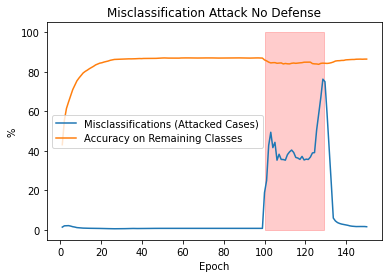

In [142]:
make_plot_better(tracks, len(other_acc), title="Misclassification Attack No Defense", y_axis_lab="%", should_average=True,  add_attack_region =(100,130), n=4)



In [118]:
sigmoid_against_noise = load_result("sigmoid_against_noise_attack_final.pickle")

In [119]:
no_defense_noise = load_result("noise_attack_1_no_defense.pickle")

In [130]:
sd = sigmoid_against_noise.test_accuracy[100:]
nd = no_defense_noise.test_accuracy[100:]
tracks2 = {
    "Sigmoid Defense" : sd,   
    "No Defense" : nd
}

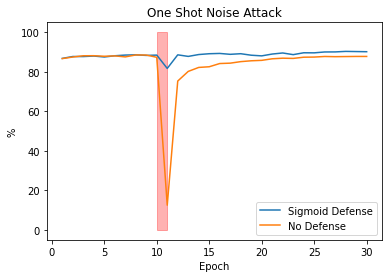

In [136]:
make_plot_better(tracks2, 30, title="One Shot Noise Attack", y_axis_lab="%", should_average=False,  add_attack_region =(10,12), n=0, alpha = .3)

In [347]:
switch_classes_sigmoid_defense_actually_train

KeyboardInterrupt: 

In [350]:
evaluate_switch_classes_attack_weights = make_evaluate_switch_classes_attack_weights(0,1)
d = [evaluate_switch_classes_attack_weights(switch_classes_sigmoid_defense_actually_train.avg_weight_history[r]) for r in range(len(switch_classes_sigmoid_defense_actually_train.avg_weight_history))]

Files already downloaded and verified
Files already downloaded and verified
 | Test Loss: 2.495 | Test Acc: 12.750
 | Test Loss: 4.315 | Test Acc: 0.000
 | Test Loss: 1.529 | Test Acc: 43.112
 | Test Loss: 3.896 | Test Acc: 1.750
 | Test Loss: 1.215 | Test Acc: 56.038
 | Test Loss: 4.935 | Test Acc: 1.600
 | Test Loss: 1.095 | Test Acc: 60.550
 | Test Loss: 5.553 | Test Acc: 2.300
 | Test Loss: 1.050 | Test Acc: 62.237
 | Test Loss: 6.340 | Test Acc: 2.600
 | Test Loss: 0.918 | Test Acc: 66.938
 | Test Loss: 6.901 | Test Acc: 1.850
 | Test Loss: 0.874 | Test Acc: 69.225
 | Test Loss: 7.538 | Test Acc: 1.900
 | Test Loss: 0.765 | Test Acc: 72.787
 | Test Loss: 8.150 | Test Acc: 1.400
 | Test Loss: 0.732 | Test Acc: 74.875
 | Test Loss: 8.904 | Test Acc: 1.350
 | Test Loss: 0.704 | Test Acc: 75.537
 | Test Loss: 9.064 | Test Acc: 1.100
 | Test Loss: 0.641 | Test Acc: 78.325
 | Test Loss: 9.676 | Test Acc: 0.850
 | Test Loss: 0.633 | Test Acc: 78.588
 | Test Loss: 9.873 | Test Acc: 1.000


 | Test Loss: 13.626 | Test Acc: 0.750
 | Test Loss: 0.612 | Test Acc: 81.275
 | Test Loss: 15.433 | Test Acc: 1.250
 | Test Loss: 0.631 | Test Acc: 81.825
 | Test Loss: 14.179 | Test Acc: 0.750
 | Test Loss: 0.733 | Test Acc: 79.487
 | Test Loss: 13.546 | Test Acc: 1.250
 | Test Loss: 0.617 | Test Acc: 81.625
 | Test Loss: 13.896 | Test Acc: 1.050
 | Test Loss: 0.565 | Test Acc: 81.888
 | Test Loss: 11.614 | Test Acc: 1.050
 | Test Loss: 0.663 | Test Acc: 80.750
 | Test Loss: 12.890 | Test Acc: 0.650
 | Test Loss: 0.744 | Test Acc: 79.963
 | Test Loss: 13.860 | Test Acc: 0.700
 | Test Loss: 0.519 | Test Acc: 83.275
 | Test Loss: 13.681 | Test Acc: 1.050
 | Test Loss: 0.686 | Test Acc: 80.300
 | Test Loss: 12.990 | Test Acc: 0.900
 | Test Loss: 0.559 | Test Acc: 83.688
 | Test Loss: 14.816 | Test Acc: 0.750
 | Test Loss: 0.554 | Test Acc: 82.925
 | Test Loss: 15.259 | Test Acc: 0.700
 | Test Loss: 0.497 | Test Acc: 84.287
 | Test Loss: 14.029 | Test Acc: 0.500
 | Test Loss: 0.592 | Tes

In [360]:
regular_acc = [x[0] for x in d]
other_acc = [x[1] for x in d]


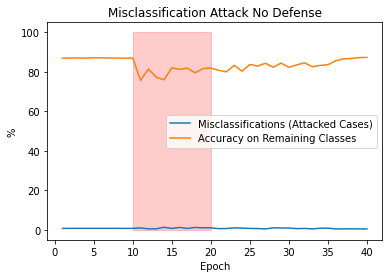

In [366]:
make_plot_better(tracks, len(other_acc[90:]), title="Misclassification Attack Sigmoid Defense", y_axis_lab="%", should_average=False,  add_attack_region =(10,21), n=4)



In [368]:
no_defense_switch_classes = load_result("switch_classes_no_defense_multiple_final_fixed_2.pickle")


d2 = [evaluate_switch_classes_attack_weights(no_defense_switch_classes.avg_weight_history[r]) for r in range(len(no_defense_switch_classes.avg_weight_history))]



 | Test Loss: 2.495 | Test Acc: 12.750
 | Test Loss: 4.315 | Test Acc: 0.000
 | Test Loss: 1.529 | Test Acc: 43.112
 | Test Loss: 3.896 | Test Acc: 1.750
 | Test Loss: 1.215 | Test Acc: 56.038
 | Test Loss: 4.935 | Test Acc: 1.600
 | Test Loss: 1.095 | Test Acc: 60.550
 | Test Loss: 5.553 | Test Acc: 2.300
 | Test Loss: 1.050 | Test Acc: 62.237
 | Test Loss: 6.340 | Test Acc: 2.600
 | Test Loss: 0.918 | Test Acc: 66.938
 | Test Loss: 6.901 | Test Acc: 1.850
 | Test Loss: 0.874 | Test Acc: 69.225
 | Test Loss: 7.538 | Test Acc: 1.900
 | Test Loss: 0.765 | Test Acc: 72.787
 | Test Loss: 8.150 | Test Acc: 1.400
 | Test Loss: 0.732 | Test Acc: 74.875
 | Test Loss: 8.904 | Test Acc: 1.350
 | Test Loss: 0.704 | Test Acc: 75.537
 | Test Loss: 9.064 | Test Acc: 1.100
 | Test Loss: 0.641 | Test Acc: 78.325
 | Test Loss: 9.676 | Test Acc: 0.850
 | Test Loss: 0.633 | Test Acc: 78.588
 | Test Loss: 9.873 | Test Acc: 1.000
 | Test Loss: 0.591 | Test Acc: 79.938
 | Test Loss: 10.739 | Test Acc: 0.95

 | Test Loss: 1.955 | Test Acc: 35.800
 | Test Loss: 0.541 | Test Acc: 83.075
 | Test Loss: 1.814 | Test Acc: 35.650
 | Test Loss: 0.439 | Test Acc: 85.575
 | Test Loss: 1.428 | Test Acc: 39.700
 | Test Loss: 0.478 | Test Acc: 84.213
 | Test Loss: 2.273 | Test Acc: 31.450
 | Test Loss: 0.519 | Test Acc: 83.037
 | Test Loss: 1.661 | Test Acc: 35.650
 | Test Loss: 0.506 | Test Acc: 83.975
 | Test Loss: 2.242 | Test Acc: 34.350
 | Test Loss: 0.460 | Test Acc: 84.912
 | Test Loss: 1.122 | Test Acc: 50.850
 | Test Loss: 0.484 | Test Acc: 84.037
 | Test Loss: 2.383 | Test Acc: 37.000
 | Test Loss: 0.488 | Test Acc: 84.250
 | Test Loss: 1.684 | Test Acc: 39.400
 | Test Loss: 0.466 | Test Acc: 84.500
 | Test Loss: 2.231 | Test Acc: 29.450
 | Test Loss: 0.491 | Test Acc: 84.325
 | Test Loss: 1.515 | Test Acc: 40.850
 | Test Loss: 0.471 | Test Acc: 84.612
 | Test Loss: 2.201 | Test Acc: 35.700
 | Test Loss: 0.469 | Test Acc: 84.625
 | Test Loss: 1.793 | Test Acc: 36.700
 | Test Loss: 0.463 | Tes

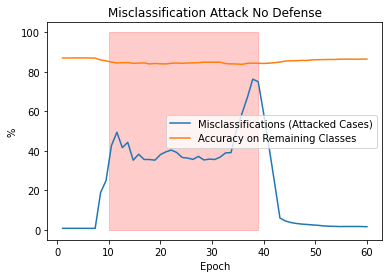

In [374]:
regular_acc_2 = [x[0] for x in d2]
other_acc_2 = [x[1] for x in d2]
tracks2 = {
    "Misclassifications (Attacked Cases)" : other_acc_2[90:],   
    "Accuracy on Remaining Classes" : regular_acc_2[90:]
}
make_plot_better(tracks2, 60, title="Misclassification Attack No Defense", y_axis_lab="%", should_average=True,  add_attack_region =(10,40), n=4)




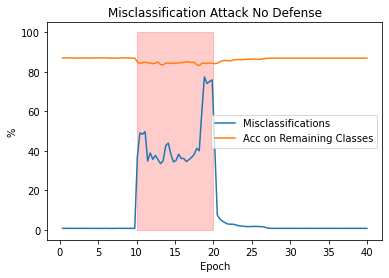

In [403]:
regular_acc_2 = [x[0] for x in d2]
other_acc_2 = [x[1] for x in d2]
tracks2 = {
    "Misclassification %" : (other_acc_2 + other_acc_4)[70:],   
    "Acc on Remaining Classes" : (regular_acc_2 + regular_acc_4)[70:]
}
make_plot_better(tracks2, 40, title="Misclassification Attack No Defense", y_axis_lab="%", should_average=True,  add_attack_region =(10,21), n=2)





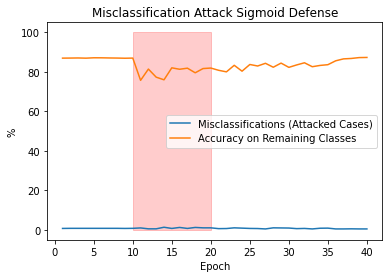

In [402]:
make_plot_better(tracks, len(other_acc[90:]), title="Misclassification Attack Sigmoid Defense", y_axis_lab="%", should_average=False,  add_attack_region =(10,21), n=3)

3.0

In [404]:
tracks = {
    "Misclassification %" : other_acc[90:],   
    "Acc on Remaining Classes" : regular_acc[90:]
}

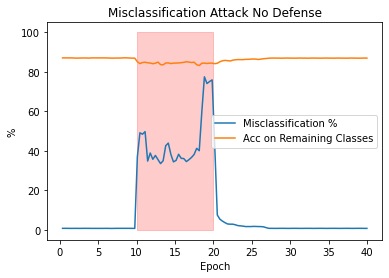

In [405]:

make_plot_better(tracks2, 40, title="Misclassification Attack No Defense", y_axis_lab="%", should_average=False,  add_attack_region =(10,21), n=2)






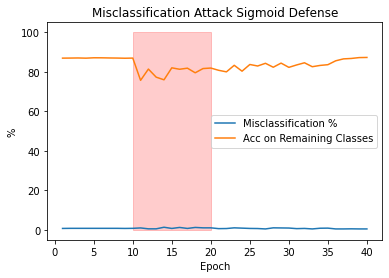

In [406]:
make_plot_better(tracks, len(other_acc[90:]), title="Misclassification Attack Sigmoid Defense", y_axis_lab="%", should_average=False,  add_attack_region =(10,21), n=3)

In [409]:
final_other = [tracks2["Misclassification %"][x:x+3] for x in range(0, len(tracks2["Misclassification %"]), 3)]



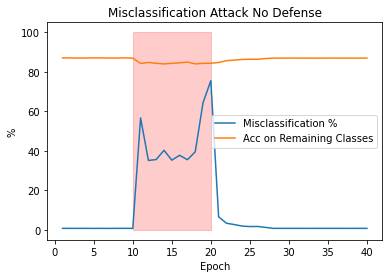

In [417]:
# regular_acc_2 = [x[0] for x in d2]
# other_acc_2 = [x[1] for x in d2]
tracks3 = {
    "Misclassification %" : final_other,   
    "Acc on Remaining Classes" : final_main
}
make_plot_better(tracks3, 40, title="Misclassification Attack No Defense", y_axis_lab="%", should_average=False,  add_attack_region =(10,21), n=2)